**Operational Blind Spots: When KPIs Hide Rising Risk**

In [2]:
# LOAD & PREPARE THE DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('/content/Berk.land.long.csv')
df.head()


,Date,originally from https://storage.googleapis.com/berkeley-earth-temperature-hr/global/Land_TAVG_monthly.txt missing value -99 https://psl.noaa.gov/data/timeseries/month/
0,1750-01-01,-1.026
1,1750-02-01,-0.501
2,1750-03-01,-0.954
3,1750-04-01,-0.839
4,1750-05-01,-0.802


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312 entries, 0 to 3311
Data columns (total 2 columns):
 #   Column                                                                                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                                                                                      --------------  -----  
 0   Date                                                                                                                                                                        3312 non-null   object 
 1     originally from https://storage.googleapis.com/berkeley-earth-temperature-hr/global/Land_TAVG_monthly.txt  missing value -99 https://psl.noaa.gov/data/timeseries/month/  3312 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.9+ KB


In [4]:
df.columns = ['date', 'temp_anomaly']
df.head()


,date,temp_anomaly
0,1750-01-01,-1.026
1,1750-02-01,-0.501
2,1750-03-01,-0.954
3,1750-04-01,-0.839
4,1750-05-01,-0.802


In [5]:
# CONVERT DATE & HANDLE MISSING VALUES
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312 entries, 0 to 3311
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3312 non-null   datetime64[ns]
 1   temp_anomaly  3312 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.9 KB


In [6]:
# Replace missing value flag
df['temp_anomaly'] = df['temp_anomaly'].replace(-99, np.nan)
df.isna().sum()


,0
date,0
temp_anomaly,0


In [7]:
# Sort & set time index
df = df.sort_values('date')
df.set_index('date', inplace=True)
df.head()


,temp_anomaly
date,
1750-01-01,-1.026
1750-02-01,-0.501
1750-03-01,-0.954
1750-04-01,-0.839
1750-05-01,-0.802


In [8]:
# DEFINE THE “DASHBOARD KPI”
# Create rolling KPI (12-month mean)
df['kpi_mean'] = df['temp_anomaly'].rolling(window=12).mean()


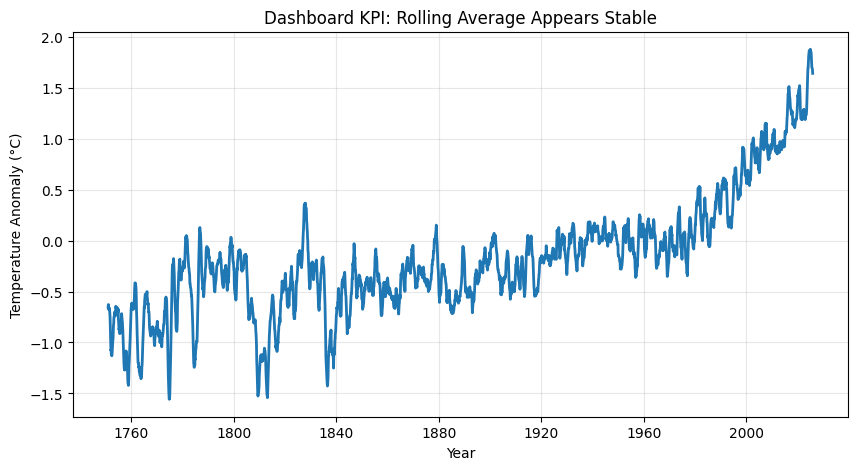

In [9]:
# Visualize KPI alone
plt.figure(figsize=(10,5))
plt.plot(df.index, df['kpi_mean'], linewidth=2)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Dashboard KPI: Rolling Average Appears Stable')
plt.grid(alpha=0.3)
plt.show()


In [10]:
# Create Hidden Risk Metric: Rolling Volatility
df['hidden_volatility'] = df['temp_anomaly'].rolling(window=12).std()


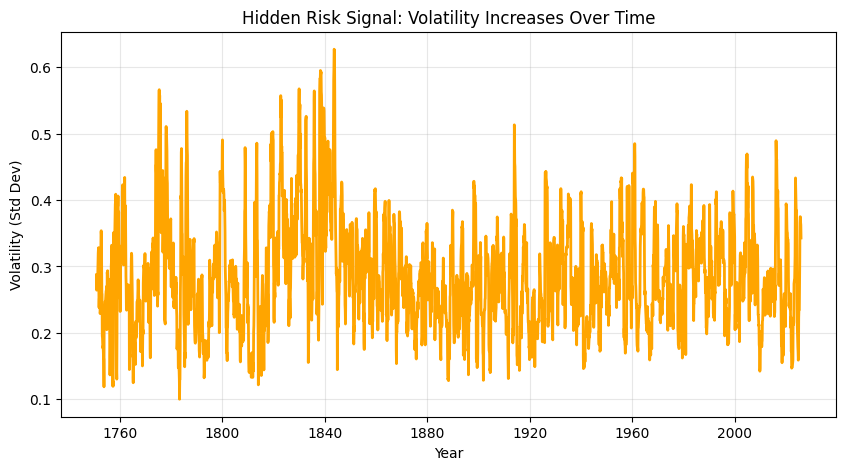

In [11]:
# Visualize Volatility Alone
plt.figure(figsize=(10,5))
plt.plot(df.index, df['hidden_volatility'], color='orange', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Volatility (Std Dev)')
plt.title('Hidden Risk Signal: Volatility Increases Over Time')
plt.grid(alpha=0.3)
plt.show()


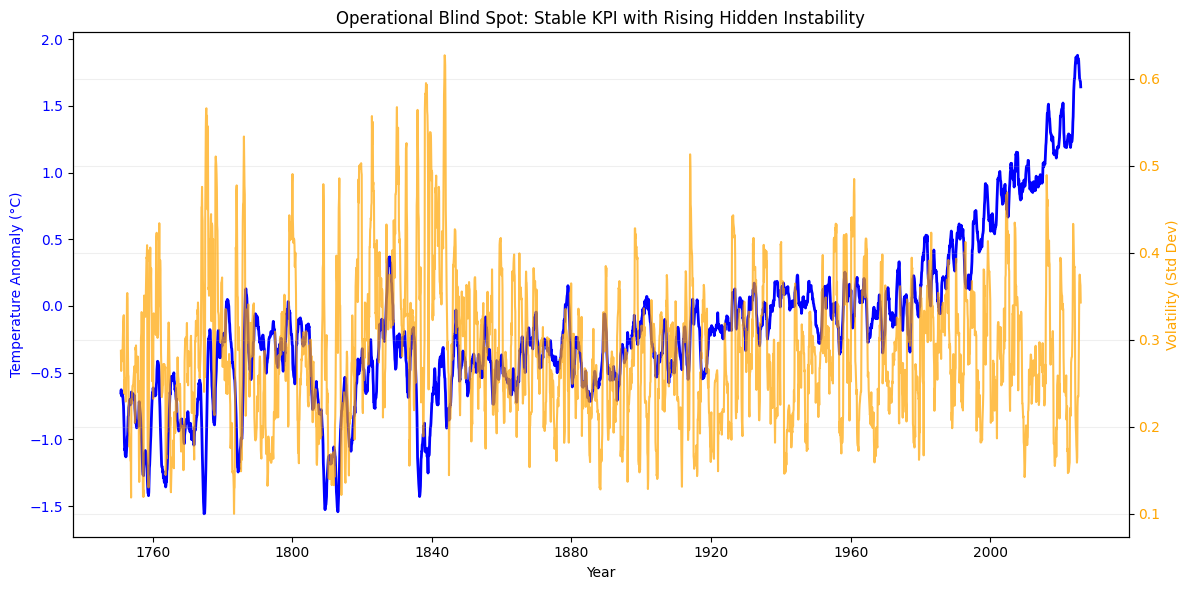

In [12]:
# KPI vs Hidden Volatility
fig, ax1 = plt.subplots(figsize=(12,6))

# Dashboard KPI (Left Axis)
ax1.plot(
    df.index,
    df['kpi_mean'],
    color='blue',
    linewidth=2,
    label='Dashboard KPI (Rolling Mean)'
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomaly (°C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Hidden Volatility (Right Axis)
ax2 = ax1.twinx()
ax2.plot(
    df.index,
    df['hidden_volatility'],
    color='orange',
    alpha=0.7,
    label='Hidden Volatility'
)
ax2.set_ylabel('Volatility (Std Dev)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Operational Blind Spot: Stable KPI with Rising Hidden Instability')
fig.tight_layout()
plt.grid(alpha=0.2)
plt.show()


In [13]:
# Normalize KPI Change & Volatility
# Rate of change in KPI (how fast the mean is moving)
df['kpi_change'] = df['kpi_mean'].diff().abs()

# Normalize both signals
df['kpi_change_norm'] = (
    df['kpi_change'] / df['kpi_change'].max()
)

df['volatility_norm'] = (
    df['hidden_volatility'] / df['hidden_volatility'].max()
)


In [14]:
# Define Blind Spot Score
df['blind_spot_score'] = (
    df['volatility_norm'] * (1 - df['kpi_change_norm'])
)


In [15]:
# Top Blind-Spot Periods
blind_spots = (
    df[['blind_spot_score']]
    .dropna()
    .sort_values(by='blind_spot_score', ascending=False)
)

blind_spots.head(10)


,blind_spot_score
date,
1843-10-01,0.957997
1838-04-01,0.920621
1838-08-01,0.905754
1838-07-01,0.900728
1838-03-01,0.898085
1838-06-01,0.839799
1839-09-01,0.833460
1830-05-01,0.825444
1838-05-01,0.819870


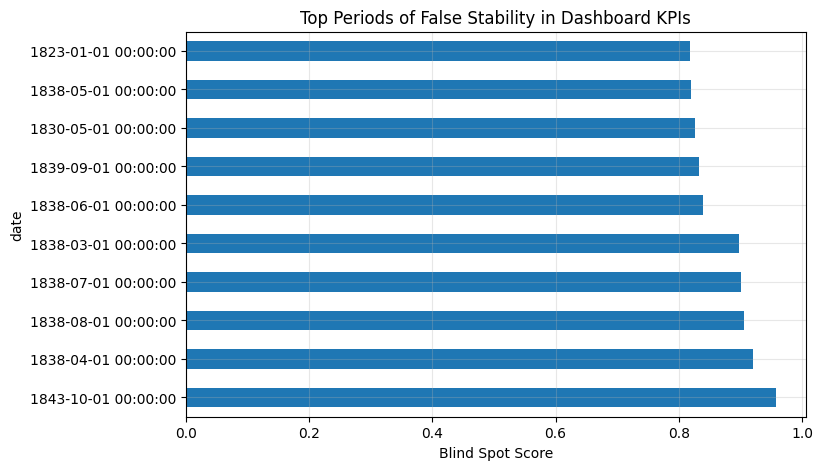

In [16]:
blind_spots.head(10).plot(
    kind='barh',
    figsize=(8,5),
    legend=False
)

plt.xlabel('Blind Spot Score')
plt.title('Top Periods of False Stability in Dashboard KPIs')
plt.grid(alpha=0.3)
plt.show()


In [17]:
final_table = (
    df.reset_index()[[
        'date',
        'temp_anomaly',
        'kpi_mean',
        'kpi_change',
        'hidden_volatility',
        'kpi_change_norm',
        'volatility_norm',
        'blind_spot_score'
    ]]
)

final_table.head(10)


,date,temp_anomaly,kpi_mean,kpi_change,hidden_volatility,kpi_change_norm,volatility_norm,blind_spot_score
0,1750-01-01,-1.026,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,-0.501,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,-0.954,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,-0.839,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,-0.802,NaN,NaN,NaN,NaN,NaN,NaN
5,1750-06-01,-0.894,NaN,NaN,NaN,NaN,NaN,NaN
6,1750-07-01,-0.812,NaN,NaN,NaN,NaN,NaN,NaN
7,1750-08-01,-0.614,NaN,NaN,NaN,NaN,NaN,NaN
8,1750-09-01,-0.620,NaN,NaN,NaN,NaN,NaN,NaN
9,1750-10-01,-0.386,NaN,NaN,NaN,NaN,NaN,NaN
